In [1]:
# General Libraries
import os
import math
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Google Colab
from google.colab import drive
import gdown

# Scikit-learn (Data Processing & ML)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

# TensorFlow & Keras (Deep Learning)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import load_model
import gc
import tensorflow.keras.backend as K

In [2]:
# Mount Google Drive
# Define Google Drive Folder ID
FOLDER_ID = "1VM2BEzEf6DWlQJjtFA5V4z5oq1DteCGd"

# Define Local Folder Path
local_data_folder = "/content/Building_59_clean_data/"

# Download the Dataset
if not os.path.exists(local_data_folder):  # Avoid downloading multiple times
    os.makedirs(local_data_folder, exist_ok=True)
    gdown.download_folder(f"https://drive.google.com/drive/folders/{FOLDER_ID}", output=local_data_folder, quiet=False, use_cookies=False)

# Load CSV Files Dynamically
csv_files = glob.glob(os.path.join(local_data_folder, "**", "*.csv"), recursive = True)

# Print Found Files
print(f" Found {len(csv_files)} CSV files in the dataset!")

 Found 27 CSV files in the dataset!


In [3]:
# Check all .csv files
print("🔍 Found CSV files:", csv_files)

all_columns = set()
for file in csv_files:
    df = pd.read_csv(file, nrows=5)  # Load only first 5 rows to check columns
    all_columns.update(df.columns)   # Add to set to avoid duplicates

# Sort and display all columns
all_columns = sorted(all_columns)
print(" All Column Names in Dataset:")
print(all_columns)

# for file in csv_files:
#     print(f"📂 File: {os.path.basename(file)}")  # Print filename
#     df = pd.read_csv(file)
#     display(df.head(5))  # Display the first 5 rows
#     print("\n" + "="*80 + "\n")  # Separator for readability


🔍 Found CSV files: ['/content/Building_59_clean_data/Building_59/Building_59_clean_data/ele.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/rtu_oa_t.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/wifi.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/rtu_sa_fr.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/rtu_ma_t.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/rtu_oa_damper.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/occ.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/rtu_sa_t.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/site_weather.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/ashp_meter.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/ashp_cw.csv', '/content/Building_59_clean_data/Building_59/Building_59_clean_data/rt

In [4]:
# Merge all essential .csv files and keep only data from the year 2020

essential_sensor_files = [
    "ele.csv",  # Electrical meter data
    "rtu_sa_t.csv",  # HVAC Supply Air temperature
    "zone_temp_interior.csv",  # Interior zone temperatures
    "zone_temp_exterior.csv",  # Exterior temperature
    "rtu_fan_spd.csv",  # Fan speeds for HVAC units
    "ashp_meter.csv",  # Air source heat pump energy use
    "ashp_cw.csv", "ashp_hw.csv",  # Chilled water & Hot water from ASHP
]

# Filter only the necessary files
filtered_files = [f for f in csv_files if os.path.basename(f) in essential_sensor_files]
print(f"🔍 Found {len(filtered_files)} essential sensor CSV files!")

# Create a full timestamp range (2020, 5-minute intervals)
full_time_index = pd.date_range(start="2020-01-01 00:00:00", end="2020-12-31 23:55:00", freq="5min")
full_time_df = pd.DataFrame({"date": full_time_index})

# Load files, fix timestamps, and align to full time range
dfs = []
for file in filtered_files:
    df = pd.read_csv(file)

    # Print shape to check if files are loading correctly
    print(f"📂 Loaded {os.path.basename(file)} with shape {df.shape}")

    # Ensure date column is datetime
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # Drop rows where date couldn't be parsed
    df = df.dropna(subset=["date"])

    # Sort and reset index
    df = df.sort_values("date").reset_index(drop=True)

    # Merge with full timestamp range using outer join
    df = full_time_df.merge(df, on="date", how="left")

    # Store cleaned dataset
    dfs.append(df)

# Merge all datasets into one using an outer join
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on="date", how="outer", suffixes=("", "_dup"))

# Drop any duplicate columns that may have been added
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]

# Display final shape & first rows
print("Final merged dataset shape:", merged_df.shape)
display(merged_df.head(20))

🔍 Found 8 essential sensor CSV files!
📂 Loaded ele.csv with shape (103048, 7)
📂 Loaded rtu_sa_t.csv with shape (1407323, 5)
📂 Loaded ashp_meter.csv with shape (43978, 2)
📂 Loaded ashp_cw.csv with shape (43979, 4)
📂 Loaded rtu_fan_spd.csv with shape (1382051, 9)
📂 Loaded zone_temp_exterior.csv with shape (1511904, 52)
📂 Loaded ashp_hw.csv with shape (124487, 4)
📂 Loaded zone_temp_interior.csv with shape (149696, 17)
Final merged dataset shape: (112368, 93)


,date,mels_S,lig_S,mels_N,hvac_N,hvac_S,Unnamed: 6,rtu_001_sa_temp,rtu_002_sa_temp,rtu_003_sa_temp,...,cerc_templogger_15,cerc_templogger_16,cerc_templogger_2,cerc_templogger_3,cerc_templogger_4,cerc_templogger_5,cerc_templogger_6,cerc_templogger_7,cerc_templogger_8,cerc_templogger_9
0,2020-01-01 00:00:00,1.757143,0.100000,8.198750,23.710526,28.021053,NaN,62.5,67.7,68.2,...,23.250,22.937,21.687,25.187,23.625,22.937,22.375,21.500,22.750,24.000
1,2020-01-01 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,65.2,67.4,68.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,64.6,68.7,68.4,...,23.312,23.000,21.687,25.187,23.687,22.812,22.437,21.562,22.937,23.875
3,2020-01-01 00:15:00,1.766667,0.087500,1.881521,8.211429,24.015000,25.880000,63.1,68.3,68.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,63.3,67.1,68.0,...,23.312,22.937,21.625,25.250,23.625,23.062,22.312,21.500,22.875,23.937
5,2020-01-01 00:25:00,NaN,NaN,NaN,NaN,NaN,NaN,64.7,67.2,68.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-01-01 00:30:00,1.900000,0.100000,3.277132,8.283333,24.975000,27.115789,61.9,67.9,67.7,...,23.312,23.062,21.625,25.250,23.625,22.812,22.375,21.562,22.750,23.812
7,2020-01-01 00:35:00,NaN,NaN,NaN,NaN,NaN,NaN,64.9,68.6,67.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,64.9,68.8,68.1,...,23.312,23.125,21.625,25.187,23.687,22.937,22.375,21.500,22.750,23.937
9,2020-01-01 00:45:00,1.800000,0.000000,1.606442,8.491667,25.700000,25.950000,62.7,69.1,67.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Verify the data

print(merged_df.columns)
#display(merged_df.head(500))
print("Total rows:", merged_df.shape[0])
print("Total columns:", merged_df.shape[1])
print(merged_df.head())
print("Columns in dataset:", merged_df.columns)
# Check the percentage of missing values in each column

# Count missing values and calculate percentage
missing_data = merged_df.isnull().sum()
missing_percentage = (missing_data / len(merged_df)) * 100

# Combine into a DataFrame
missing_summary = pd.DataFrame({
    "Missing Count": missing_data,
    "Missing Percentage": missing_percentage
})

# Display missing data sorted by percentage
missing_summary = missing_summary.sort_values(by="Missing Percentage", ascending=False)
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # Show all columns
print(missing_summary)

Index(['date', 'mels_S', 'lig_S', 'mels_N', 'hvac_N', 'hvac_S', 'Unnamed: 6',
       'rtu_001_sa_temp', 'rtu_002_sa_temp', 'rtu_003_sa_temp',
       'rtu_004_sa_temp', 'aru_001_power_mbtuph', 'aru_001_cwr_temp',
       'aru_001_cws_fr_gpm', 'aru_001_cws_temp', 'rtu_001_sf_vfd_spd_fbk_tn',
       'rtu_002_sf_vfd_spd_fbk_tn', 'rtu_003_sf_vfd_spd_fbk_tn',
       'rtu_004_sf_vfd_spd_fbk_tn', 'rtu_001_rf_vfd_spd_fbk_tn',
       'rtu_002_rf_vfd_spd_fbk_tn', 'rtu_003_rf_vfd_spd_fbk_tn',
       'rtu_004_rf_vfd_spd_fbk_tn', 'zone_016_temp', 'zone_017_temp',
       'zone_018_temp', 'zone_019_temp', 'zone_021_temp', 'zone_022_temp',
       'zone_023_temp', 'zone_024_temp', 'zone_025_temp', 'zone_026_temp',
       'zone_027_temp', 'zone_028_temp', 'zone_030_temp', 'zone_032_temp',
       'zone_033_temp', 'zone_035_temp', 'zone_036_temp', 'zone_037_temp',
       'zone_038_temp', 'zone_039_temp', 'zone_040_temp', 'zone_041_temp',
       'zone_042_temp', 'zone_043_temp', 'zone_044_temp', 'zone_045_te

In [6]:
# Interpolate the missing data, interpolate the gaps with pandas:
merged_df.interpolate(method="linear", inplace=True)
merged_df.fillna(method="ffill", inplace=True)  # Forward Fill
merged_df.fillna(method="bfill", inplace=True)  # Backward Fill
print("Final Missing Values Check:")
print(merged_df.isna().sum().sort_values(ascending=False))
print("Final Shape of Cleaned Dataset:", merged_df.shape)
display(merged_df.head())


Final Missing Values Check:
cerc_templogger_9            0
date                         0
mels_S                       0
lig_S                        0
mels_N                       0
cerc_templogger_1            0
cerc_templogger_10           0
cerc_templogger_11           0
cerc_templogger_12           0
cerc_templogger_13           0
cerc_templogger_14           0
cerc_templogger_15           0
cerc_templogger_16           0
aru_001_cws_fr_gpm           0
aru_001_cws_temp             0
rtu_001_sf_vfd_spd_fbk_tn    0
rtu_002_sf_vfd_spd_fbk_tn    0
rtu_003_sf_vfd_spd_fbk_tn    0
rtu_004_sf_vfd_spd_fbk_tn    0
rtu_001_rf_vfd_spd_fbk_tn    0
rtu_002_rf_vfd_spd_fbk_tn    0
rtu_003_rf_vfd_spd_fbk_tn    0
rtu_004_rf_vfd_spd_fbk_tn    0
zone_016_temp                0
zone_017_temp                0
zone_018_temp                0
zone_019_temp                0
zone_021_temp                0
zone_022_temp                0
zone_023_temp                0
zone_024_temp                0
zone_025_te

<ipython-input-6-da479b3a5379>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method="ffill", inplace=True)  # Forward Fill
<ipython-input-6-da479b3a5379>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method="bfill", inplace=True)  # Backward Fill


,date,mels_S,lig_S,mels_N,hvac_N,hvac_S,Unnamed: 6,rtu_001_sa_temp,rtu_002_sa_temp,rtu_003_sa_temp,rtu_004_sa_temp,aru_001_power_mbtuph,aru_001_cwr_temp,aru_001_cws_fr_gpm,aru_001_cws_temp,rtu_001_sf_vfd_spd_fbk_tn,rtu_002_sf_vfd_spd_fbk_tn,rtu_003_sf_vfd_spd_fbk_tn,rtu_004_sf_vfd_spd_fbk_tn,rtu_001_rf_vfd_spd_fbk_tn,rtu_002_rf_vfd_spd_fbk_tn,rtu_003_rf_vfd_spd_fbk_tn,rtu_004_rf_vfd_spd_fbk_tn,zone_016_temp,zone_017_temp,zone_018_temp,zone_019_temp,zone_021_temp,zone_022_temp,zone_023_temp,zone_024_temp,zone_025_temp,zone_026_temp,zone_027_temp,zone_028_temp,zone_030_temp,zone_032_temp,zone_033_temp,zone_035_temp,zone_036_temp,zone_037_temp,zone_038_temp,zone_039_temp,zone_040_temp,zone_041_temp,zone_042_temp,zone_043_temp,zone_044_temp,zone_045_temp,zone_046_temp,zone_047_temp,zone_048_temp,zone_049_temp,zone_051_temp,zone_052_temp,zone_053_temp,zone_054_temp,zone_055_temp,zone_056_temp,zone_057_temp,zone_058_temp,zone_059_temp,zone_061_temp,zone_062_temp,zone_063_temp,zone_064_temp,zone_065_temp,zone_066_temp,zone_067_temp,zone_068_temp,zone_069_temp,zone_070_temp,zone_071_temp,zone_072_temp,aru_001_hwr_temp,aru_001_hws_fr_gpm,aru_001_hws_temp,cerc_templogger_1,cerc_templogger_10,cerc_templogger_11,cerc_templogger_12,cerc_templogger_13,cerc_templogger_14,cerc_templogger_15,cerc_templogger_16,cerc_templogger_2,cerc_templogger_3,cerc_templogger_4,cerc_templogger_5,cerc_templogger_6,cerc_templogger_7,cerc_templogger_8,cerc_templogger_9
0,2020-01-01 00:00:00,1.757143,0.100000,8.198750,23.710526,28.021053,25.88000,62.5,67.7,68.2,67.4,8.614244,63.05,80.2,63.08,80.1,81.0,80.0,80.7,53.4,61.7,48.5,82.8,74.4,71.1,71.2,73.6,69.1,71.9,70.6,72.8,71.3,72.4,72.5,74.3,72.0,70.9,70.0,69.5,70.9,69.1,72.0,71.2,74.6,74.6,74.0,76.6,75.6,71.5,70.5,71.0,70.2,72.1,68.6,71.5,71.8,70.2,69.6,71.5,72.4,74.7,71.8,71.6,71.9,71.3,72.0,70.9,71.3,71.6,73.2,72.7,71.6,73.0,73.2,121.55,62.36,126.27,22.6870,0.000000,24.0000,23.9370,23.9370,23.312,23.250,22.9370,21.687,25.1870,23.625,22.9370,22.3750,21.500,22.7500,24.0000
1,2020-01-01 00:05:00,1.760317,0.095833,6.093007,18.544160,26.685702,25.88000,65.2,67.4,68.7,67.7,8.614244,63.05,80.2,63.08,80.7,81.4,80.7,81.4,60.8,67.8,51.6,91.0,74.4,71.1,71.3,73.6,69.2,71.9,70.7,72.8,71.3,72.6,72.6,74.3,72.0,70.9,70.0,69.5,70.9,69.2,72.0,71.2,75.1,74.7,74.0,76.6,75.6,71.5,70.5,71.0,70.2,72.1,68.6,72.2,71.9,70.4,69.7,71.6,72.6,74.7,71.8,71.7,71.9,71.3,72.0,71.0,71.3,71.6,73.2,73.0,71.7,73.5,73.2,120.95,62.26,121.87,22.7185,12.014907,24.1560,23.9685,24.1245,23.312,23.281,22.9685,21.687,25.1870,23.656,22.8745,22.4060,21.531,22.8435,23.9375
2,2020-01-01 00:10:00,1.763492,0.091667,3.987264,13.377794,25.350351,25.88000,64.6,68.7,68.4,67.6,8.614244,63.05,80.2,63.08,82.4,83.7,82.7,82.6,58.5,61.3,54.6,91.5,74.4,71.1,71.3,73.6,69.2,71.9,70.8,72.9,71.4,72.6,72.7,74.3,72.0,70.9,69.7,69.5,70.9,69.2,72.0,71.0,75.3,74.7,74.1,76.7,75.6,71.5,70.5,71.0,70.2,72.1,68.6,72.7,71.9,70.4,69.7,71.7,73.4,75.0,71.8,71.7,71.9,71.3,72.0,71.0,71.3,71.5,73.2,74.0,71.7,73.7,73.2,117.23,62.26,121.76,22.7500,24.029814,24.3120,24.0000,24.3120,23.312,23.312,23.0000,21.687,25.1870,23.687,22.8120,22.4370,21.562,22.9370,23.8750
3,2020-01-01 00:15:00,1.766667,0.087500,1.881521,8.211429,24.015000,25.88000,63.1,68.3,68.1,67.3,8.614244,63.05,80.2,63.08,80.2,81.0,79.8,80.5,62.8,57.4,53.8,89.2,74.4,71.1,71.3,73.6,69.2,71.9,70.8,72.9,71.4,72.7,73.4,74.6,72.0,70.9,70.0,69.6,70.9,69.2,72.0,71.0,75.6,74.8,74.2,76.7,75.9,71.5,70.5,70.9,70.3,72.1,68.6,73.2,71.9,70.5,69.8,71.7,73.8,75.0,71.8,71.7,71.9,71.3,72.1,71.0,71.3,71.5,73.2,74.6,71.8,73.8,73.2,120.61,62.25,125.12,22.7500,24.023496,24.3435,23.9375,24.0935,23.312,23.312,22.9685,21.656,25.2185,23.656,22.9370,22.3745,21.531,22.9060,23.9060
4,2020-01-01 00:20:00,1.811111,0.091667,2.346725,8.235397,24.335000,26.29193,63.3,67.1,68.0,67.4,8.614244,63.05,80.2,63.08,83.0,83.8,82.7,83.1,59.0,64.2,55.2,93.7,74.4,71.1,71.3,73.6,69.2,71.9,70.8,72.9,71.5,72.7,73.9,74.8,72.0,70.9,70.0,69.6,70.9,69.2,72.0,71.0,75.6,74.7,74.2,76.6,75.6

In [7]:
# Normalize the data
# Identify numerical columns (excluding 'date')
numeric_cols = merged_df.select_dtypes(include=["float64", "int64"]).columns.tolist()
print("🔍 Numerical Columns for Normalization:", numeric_cols)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply MinMax Scaling ONLY to numerical columns
merged_df[numeric_cols] = scaler.fit_transform(merged_df[numeric_cols])

# Check to ensure all values are normalized
for col in numeric_cols:
    min_val, max_val = merged_df[col].min(), merged_df[col].max()
    if min_val < 0 or max_val > 1:
        print(f"Warning: Column '{col}' has values outside [0, 1]. Min: {min_val}, Max: {max_val}")
    else:
        print(f"Column '{col}' is correctly normalized. Min: {min_val}, Max: {max_val}")

print("Normalization complete!")
display(merged_df.head())


🔍 Numerical Columns for Normalization: ['mels_S', 'lig_S', 'mels_N', 'hvac_N', 'hvac_S', 'Unnamed: 6', 'rtu_001_sa_temp', 'rtu_002_sa_temp', 'rtu_003_sa_temp', 'rtu_004_sa_temp', 'aru_001_power_mbtuph', 'aru_001_cwr_temp', 'aru_001_cws_fr_gpm', 'aru_001_cws_temp', 'rtu_001_sf_vfd_spd_fbk_tn', 'rtu_002_sf_vfd_spd_fbk_tn', 'rtu_003_sf_vfd_spd_fbk_tn', 'rtu_004_sf_vfd_spd_fbk_tn', 'rtu_001_rf_vfd_spd_fbk_tn', 'rtu_002_rf_vfd_spd_fbk_tn', 'rtu_003_rf_vfd_spd_fbk_tn', 'rtu_004_rf_vfd_spd_fbk_tn', 'zone_016_temp', 'zone_017_temp', 'zone_018_temp', 'zone_019_temp', 'zone_021_temp', 'zone_022_temp', 'zone_023_temp', 'zone_024_temp', 'zone_025_temp', 'zone_026_temp', 'zone_027_temp', 'zone_028_temp', 'zone_030_temp', 'zone_032_temp', 'zone_033_temp', 'zone_035_temp', 'zone_036_temp', 'zone_037_temp', 'zone_038_temp', 'zone_039_temp', 'zone_040_temp', 'zone_041_temp', 'zone_042_temp', 'zone_043_temp', 'zone_044_temp', 'zone_045_temp', 'zone_046_temp', 'zone_047_temp', 'zone_048_temp', 'zone_049_

,date,mels_S,lig_S,mels_N,hvac_N,hvac_S,Unnamed: 6,rtu_001_sa_temp,rtu_002_sa_temp,rtu_003_sa_temp,rtu_004_sa_temp,aru_001_power_mbtuph,aru_001_cwr_temp,aru_001_cws_fr_gpm,aru_001_cws_temp,rtu_001_sf_vfd_spd_fbk_tn,rtu_002_sf_vfd_spd_fbk_tn,rtu_003_sf_vfd_spd_fbk_tn,rtu_004_sf_vfd_spd_fbk_tn,rtu_001_rf_vfd_spd_fbk_tn,rtu_002_rf_vfd_spd_fbk_tn,rtu_003_rf_vfd_spd_fbk_tn,rtu_004_rf_vfd_spd_fbk_tn,zone_016_temp,zone_017_temp,zone_018_temp,zone_019_temp,zone_021_temp,zone_022_temp,zone_023_temp,zone_024_temp,zone_025_temp,zone_026_temp,zone_027_temp,zone_028_temp,zone_030_temp,zone_032_temp,zone_033_temp,zone_035_temp,zone_036_temp,zone_037_temp,zone_038_temp,zone_039_temp,zone_040_temp,zone_041_temp,zone_042_temp,zone_043_temp,zone_044_temp,zone_045_temp,zone_046_temp,zone_047_temp,zone_048_temp,zone_049_temp,zone_051_temp,zone_052_temp,zone_053_temp,zone_054_temp,zone_055_temp,zone_056_temp,zone_057_temp,zone_058_temp,zone_059_temp,zone_061_temp,zone_062_temp,zone_063_temp,zone_064_temp,zone_065_temp,zone_066_temp,zone_067_temp,zone_068_temp,zone_069_temp,zone_070_temp,zone_071_temp,zone_072_temp,aru_001_hwr_temp,aru_001_hws_fr_gpm,aru_001_hws_temp,cerc_templogger_1,cerc_templogger_10,cerc_templogger_11,cerc_templogger_12,cerc_templogger_13,cerc_templogger_14,cerc_templogger_15,cerc_templogger_16,cerc_templogger_2,cerc_templogger_3,cerc_templogger_4,cerc_templogger_5,cerc_templogger_6,cerc_templogger_7,cerc_templogger_8,cerc_templogger_9
0,2020-01-01 00:00:00,0.150193,0.013905,0.804597,0.720685,0.392732,0.399310,0.681570,0.685223,0.748628,0.785548,0.02026,0.665329,0.422027,0.557672,0.8408,0.8480,0.8400,0.8456,0.637917,0.744206,0.692743,0.8624,0.765714,0.513661,0.55414,0.166078,0.510638,0.625,0.517179,0.651515,0.555556,0.521053,0.465241,0.543860,0.54,0.526786,0.492063,0.416058,0.406015,0.321839,0.48538,0.391837,0.614286,0.606635,0.456731,0.724324,0.607143,0.437037,0.564103,0.518919,0.488889,0.330189,0.488506,0.708122,0.522388,0.497207,0.431034,0.472222,0.469274,0.546798,0.516129,0.450382,0.368421,0.483146,0.478632,0.413580,0.474453,0.507576,0.508108,0.426230,0.477707,0.412121,0.564516,0.927623,0.916622,0.957464,0.045933,0.000000,0.503252,0.489130,0.604774,0.554712,0.857143,0.074557,0.423518,0.296318,0.614667,0.055185,0.111124,0.340761,0.630277,0.585714
1,2020-01-01 00:05:00,0.150421,0.013517,0.608455,0.563652,0.374016,0.399310,0.711014,0.682186,0.754116,0.789044,0.02026,0.665329,0.422027,0.557672,0.8456,0.8512,0.8456,0.8512,0.698129,0.796567,0.721960,0.9280,0.765714,0.513661,0.56051,0.166078,0.515957,0.625,0.521881,0.651515,0.555556,0.531579,0.470588,0.543860,0.54,0.526786,0.492063,0.416058,0.406015,0.327586,0.48538,0.391837,0.638095,0.611374,0.456731,0.724324,0.607143,0.437037,0.564103,0.518919,0.488889,0.330189,0.488506,0.725888,0.527363,0.508380,0.436782,0.477778,0.480447,0.546798,0.516129,0.458015,0.368421,0.483146,0.478632,0.419753,0.474453,0.507576,0.508108,0.442623,0.484076,0.442424,0.564516,0.921541,0.915149,0.914139,0.046415,0.432004,0.519356,0.491870,0.628968,0.554712,0.858286,0.075026,0.423518,0.296318,0.619833,0.054234,0.112028,0.344435,0.642848,0.578571
2,2020-01-01 00:10:00,0.150649,0.013130,0.412313,0.406620,0.355301,0.399310,0.704471,0.695344,0.750823,0.787879,0.02026,0.665329,0.422027,0.557672,0.8592,0.8696,0.8616,0.8608,0.679414,0.740773,0.750236,0.9320,0.765714,0.513661,0.56051,0.166078,0.515957,0.625,0.526582,0.656566,0.561728,0.531579,0.475936,0.543860,0.54,0.526786,0.468254,0.416058,0.406015,0.327586,0.48538,0.383673,0.647619,0.611374,0.461538,0.729730,0.607143,0.437037,0.564103,0.518919,0.488889,0.330189,0.488506,0.738579,0.527363,0.508380,0.436782,0.483333,0.525140,0.561576,0.516129,0.458015,0.368421,0.483146,0.478632,0.419753,0.474453,0.500000,0.508108,0.497268,0.484076,0.454545,0.564516,0.883832,0.915149,0.913056,0.046897,0.864009,0.535460,0.494609,0.653161,0.554712,0.859429,0.075496,0.423518,0.296318,0.625000,0.053282,0.112931,0.348110,0.655418,0.571429
3,2020-01-01 00:15:00,0.150876,0.012743,0.216171,0.

Min and Max values of normalized energy_scaled:
Min: date                         2020-01-01 00:00:00
mels_S                                       0.0
lig_S                                        0.0
mels_N                                       0.0
hvac_N                                       0.0
hvac_S                                       0.0
Unnamed: 6                                   0.0
rtu_001_sa_temp                              0.0
rtu_002_sa_temp                              0.0
rtu_003_sa_temp                              0.0
rtu_004_sa_temp                              0.0
aru_001_power_mbtuph                         0.0
aru_001_cwr_temp                             0.0
aru_001_cws_fr_gpm                           0.0
aru_001_cws_temp                             0.0
rtu_001_sf_vfd_spd_fbk_tn                    0.0
rtu_002_sf_vfd_spd_fbk_tn                    0.0
rtu_003_sf_vfd_spd_fbk_tn                    0.0
rtu_004_sf_vfd_spd_fbk_tn                    0.0
rtu_001_rf_vfd_s

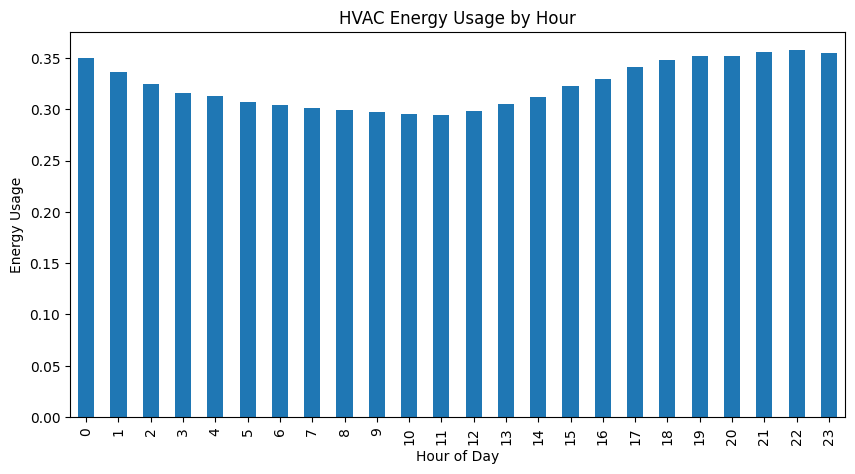

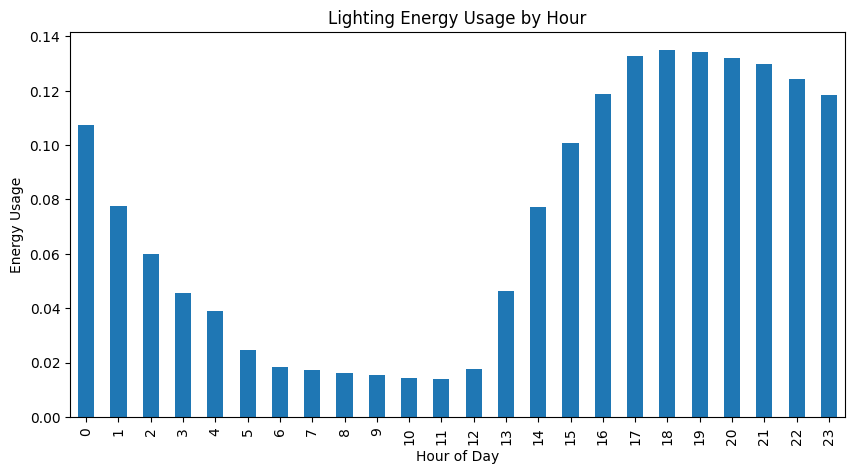

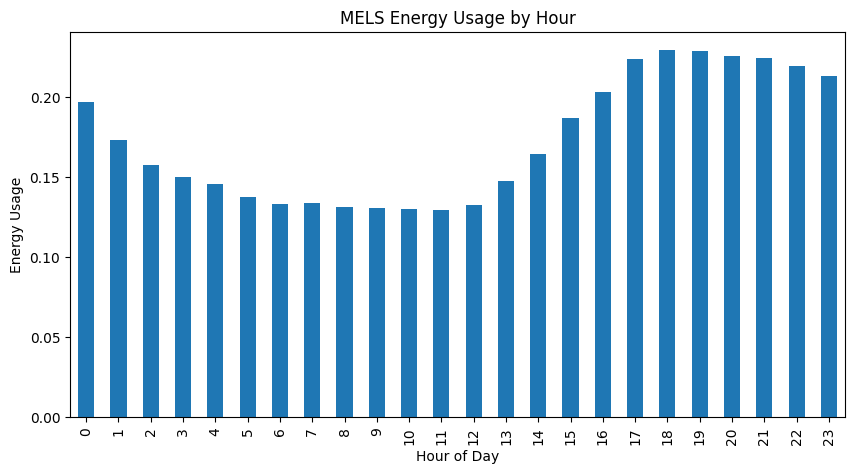

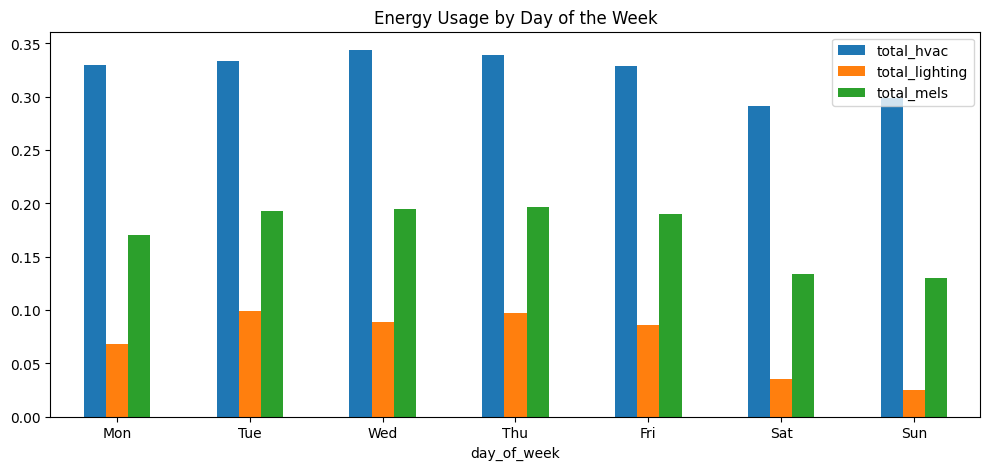

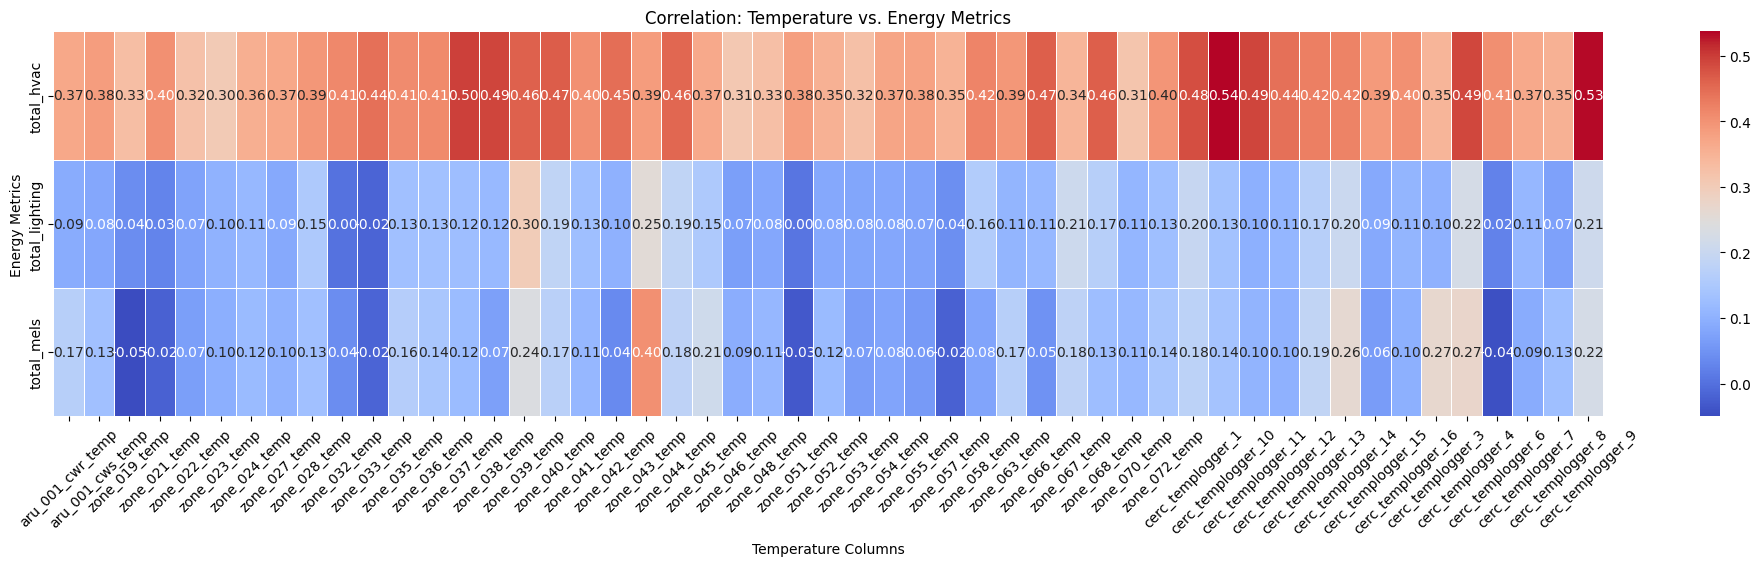

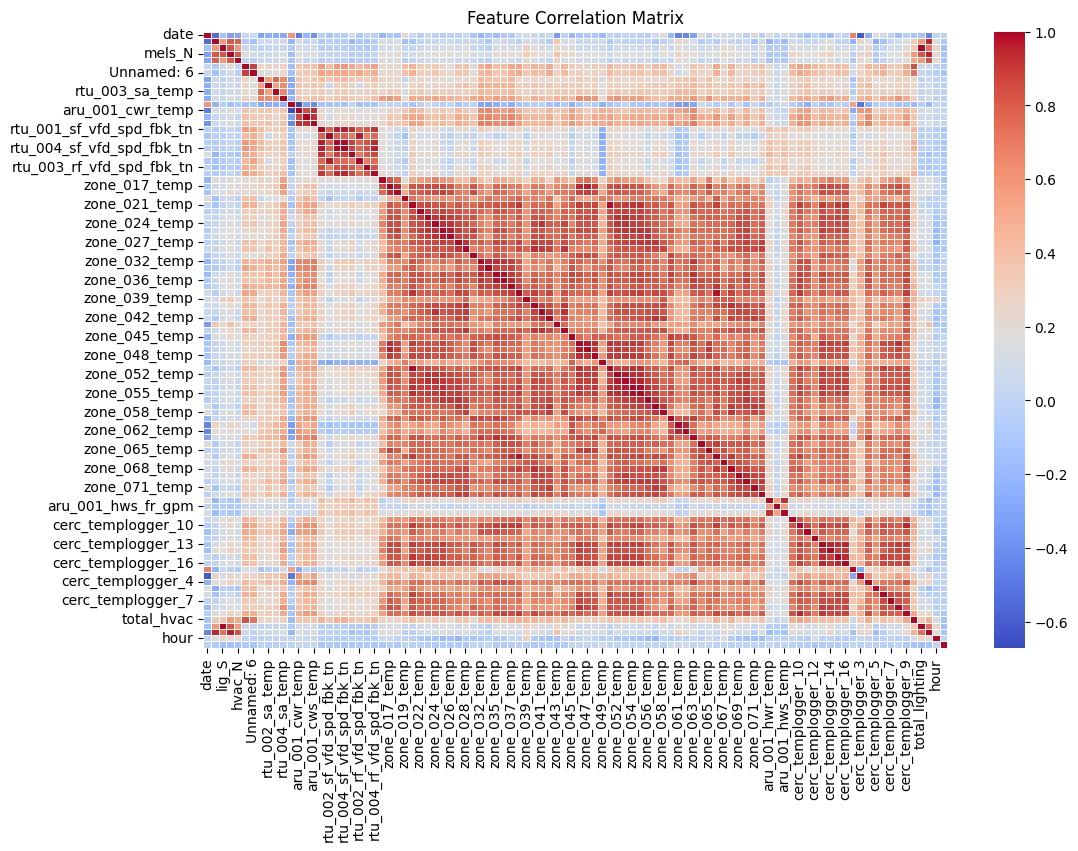

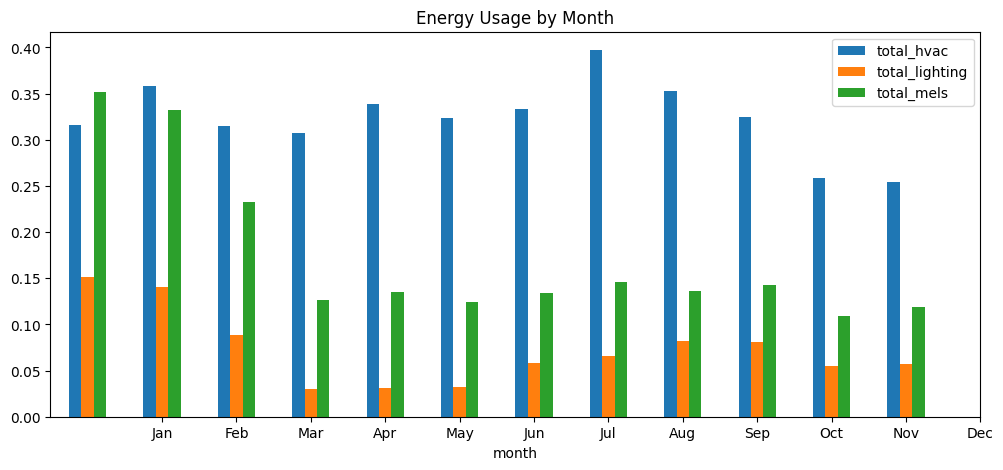

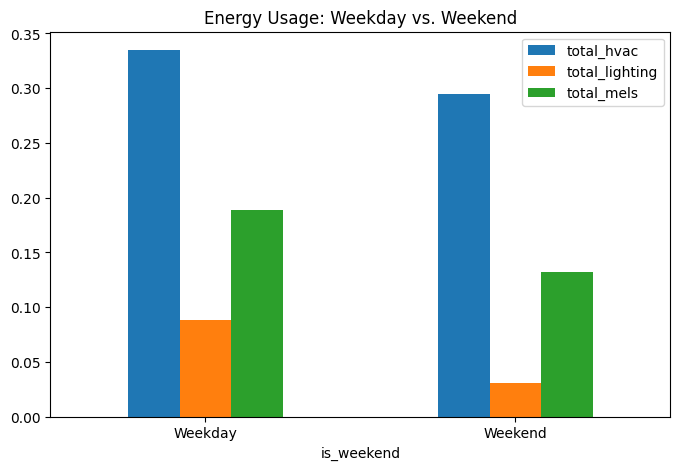

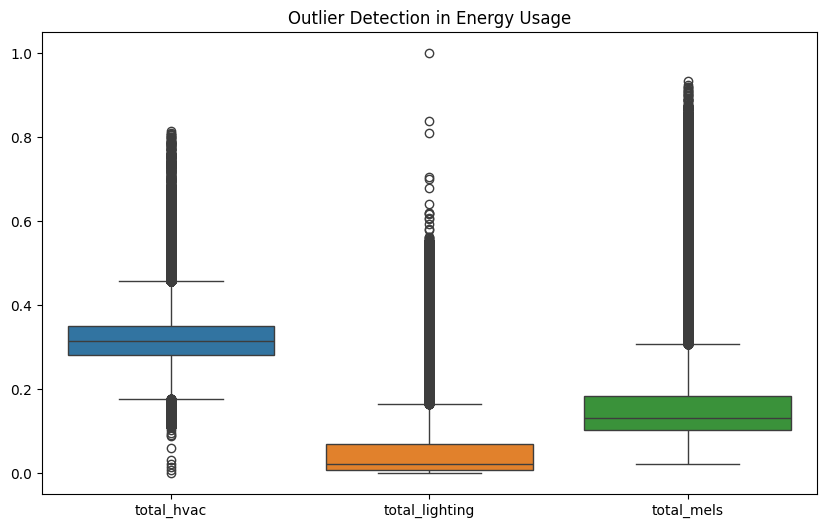

In [8]:
# Do Statistical analysis on trends and peak times before AI forecasting

# Define different energy categories
y_hvac = (merged_df["hvac_N"] + merged_df["hvac_S"]) / 2  # HVAC Energy (Averaged)
y_lighting = merged_df["lig_S"]  # Lighting Energy (Single Source)
y_mels = (merged_df["mels_N"] + merged_df["mels_S"]) / 2  # Miscellaneous Load (Averaged)

# Add them back to the dataset
merged_df["total_hvac"] = y_hvac
merged_df["total_lighting"] = y_lighting
merged_df["total_mels"] = y_mels
merged_df["hour"] = merged_df["date"].dt.hour

# HVAC Energy Usage by Hour
hvac_hourly = merged_df.groupby("hour")["total_hvac"].mean()
plt.figure(figsize=(10, 5))
hvac_hourly.plot(kind="bar", title="HVAC Energy Usage by Hour")
plt.ylabel("Energy Usage")
plt.xlabel("Hour of Day")
plt.show()

# Lighting Energy Usage by Hour
lighting_hourly = merged_df.groupby("hour")["total_lighting"].mean()
plt.figure(figsize=(10, 5))
lighting_hourly.plot(kind="bar", title="Lighting Energy Usage by Hour")
plt.ylabel("Energy Usage")
plt.xlabel("Hour of Day")
plt.show()

# MELS Energy Usage by Hour
mels_hourly = merged_df.groupby("hour")["total_mels"].mean()
plt.figure(figsize=(10, 5))
mels_hourly.plot(kind="bar", title="MELS Energy Usage by Hour")
plt.ylabel("Energy Usage")
plt.xlabel("Hour of Day")
plt.show()

# Extract day of the week and compute averages and trends
merged_df["day_of_week"] = merged_df["date"].dt.dayofweek

# Compute weekly average
weekly_usage = merged_df.groupby("day_of_week")[["total_hvac", "total_lighting", "total_mels"]].mean()

# Plot weekly trends
weekly_usage.plot(kind="bar", figsize=(12, 5), title="Energy Usage by Day of the Week")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], rotation=0)
plt.show()

# Correlation between temperature & HVAC, lighting and miscilanious energy usage
energy_metrics = ["total_hvac", "total_lighting", "total_mels"]
temp_cols = [col for col in merged_df.columns if "temp" in col]
corr_matrix = merged_df[temp_cols + energy_metrics].corr()

threshold = 0.3 # threshold correlation
filtered_corr = corr_matrix.loc[energy_metrics, temp_cols]
significant_temp_cols = filtered_corr.columns[(filtered_corr.abs() > threshold).any()]
filtered_corr = filtered_corr[significant_temp_cols]

plt.figure(figsize=(25, 5))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation: Temperature vs. Energy Metrics")
plt.xlabel("Temperature Columns")
plt.ylabel("Energy Metrics")
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Compute correlation matrix
correlation_matrix = merged_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Compute monthly and weekday vs. weekend trends
merged_df["month"] = merged_df["date"].dt.month
monthly_usage = merged_df.groupby("month")[["total_hvac", "total_lighting", "total_mels"]].mean()

monthly_usage.plot(kind="bar", figsize=(12, 5), title="Energy Usage by Month")
plt.xticks(ticks=range(1, 13), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], rotation=0)
plt.show()

merged_df["is_weekend"] = merged_df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
weekend_usage = merged_df.groupby("is_weekend")[["total_hvac", "total_lighting", "total_mels"]].mean()

weekend_usage.plot(kind="bar", figsize=(8, 5), title="Energy Usage: Weekday vs. Weekend", legend=True)
plt.xticks(ticks=[0, 1], labels=["Weekday", "Weekend"], rotation=0)
plt.show()

# Compute boxplots for outlier detection
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df[["total_hvac", "total_lighting", "total_mels"]])
plt.title("Outlier Detection in Energy Usage")
plt.show()

<ipython-input-9-d0bada43c07a>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df["day"] = merged_df["date"].dt.date


Min and Max values of normalized energy_scaled:
Min: 0.0
Max: 1.0


<ipython-input-9-d0bada43c07a>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df["usage_cluster"] = kmeans.fit_predict(energy_scaled)


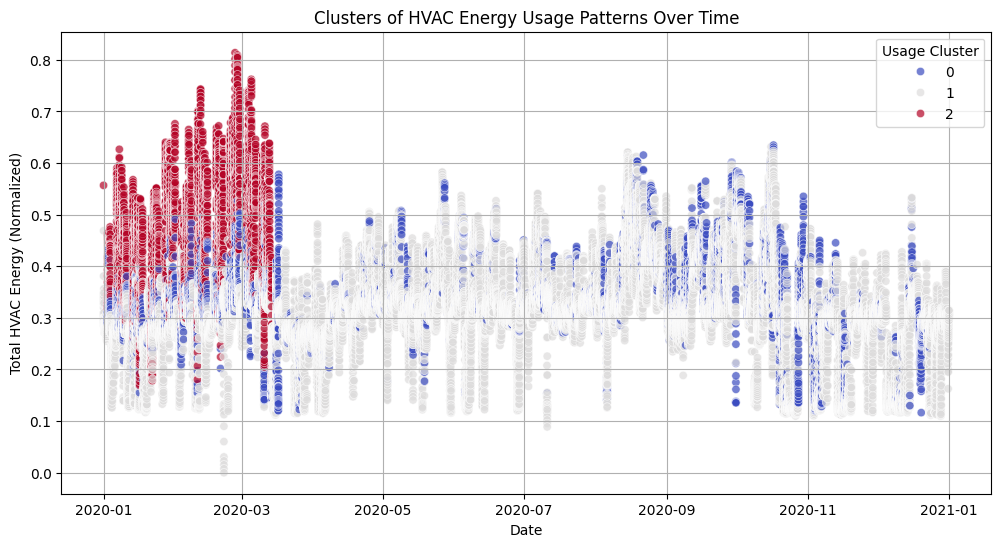

<Figure size 1200x500 with 0 Axes>

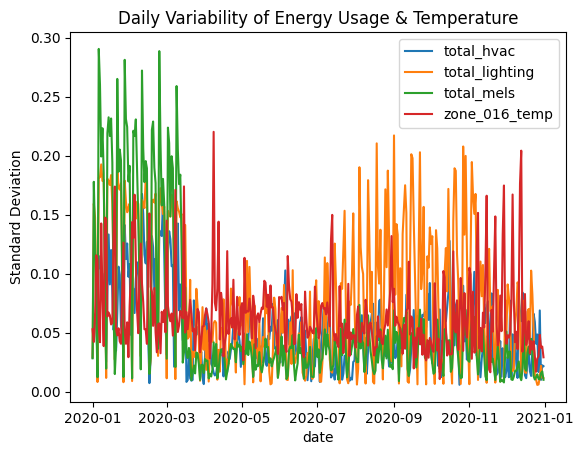

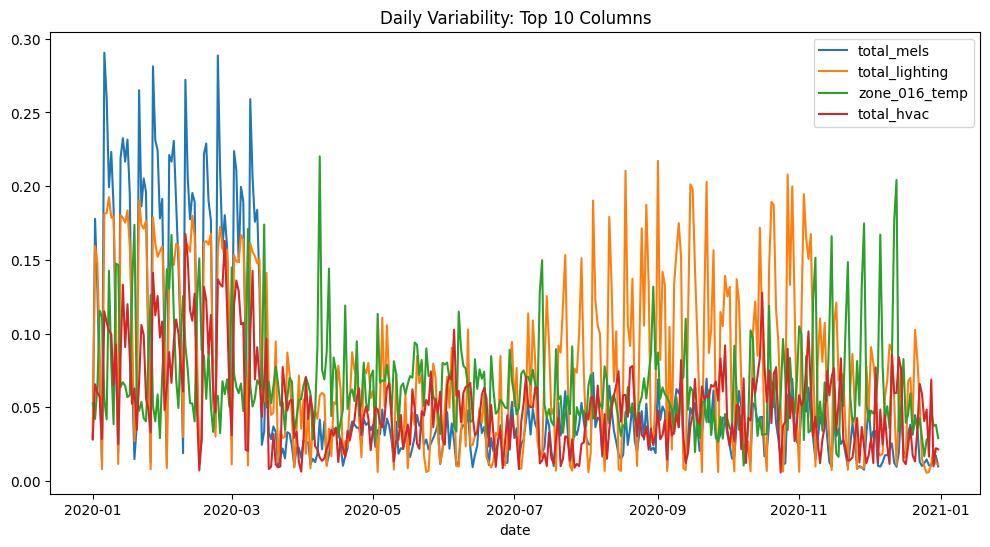

Correlation between HVAC Usage & Temperature Change:
             temp_change  total_hvac
temp_change     1.000000   -0.011447
total_hvac     -0.011447    1.000000


<ipython-input-9-d0bada43c07a>:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df["temp_change"] = merged_df["zone_016_temp"].diff()


<Figure size 1200x500 with 0 Axes>

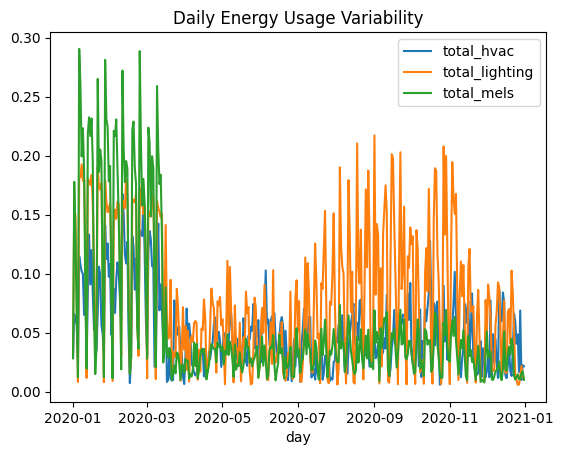

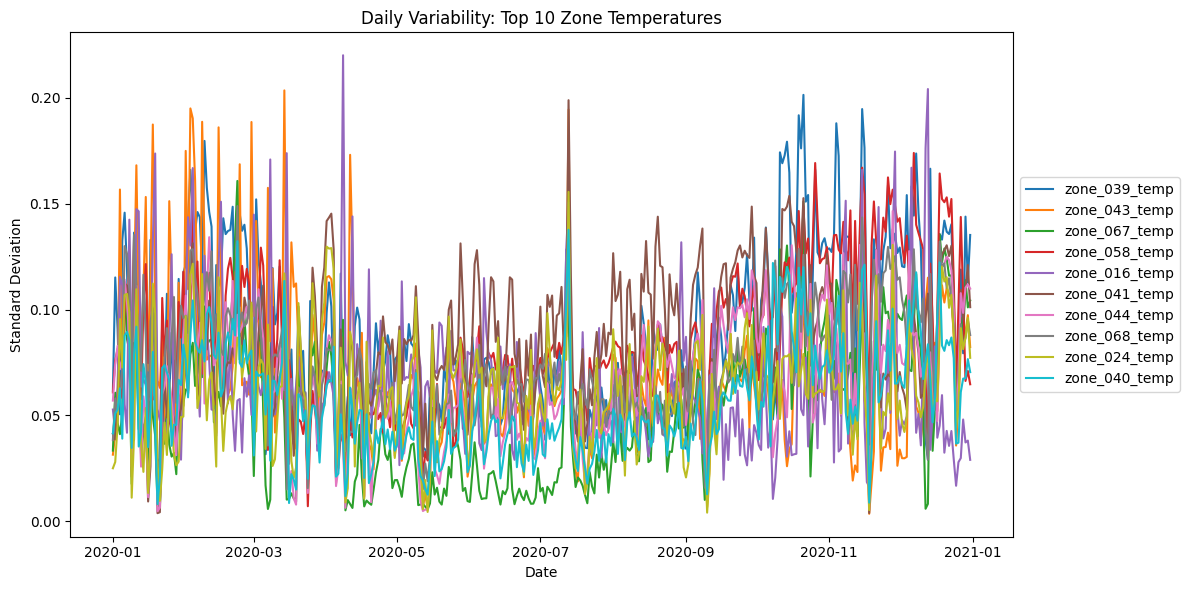

<Figure size 1200x500 with 0 Axes>

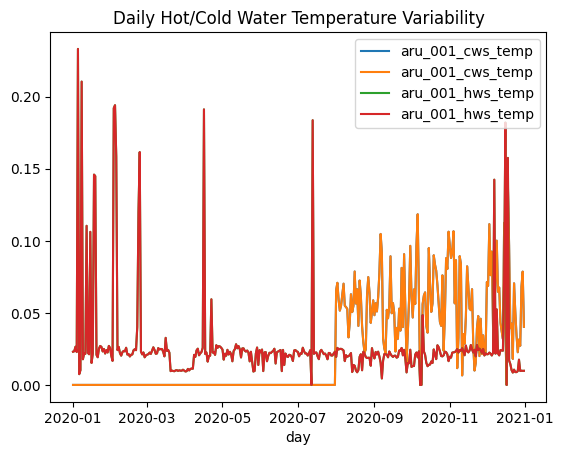

In [9]:
# Do analysis on the varibility of the data for insights on the utility of AI
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Extract time components
merged_df["hour"] = merged_df["date"].dt.hour
merged_df["day"] = merged_df["date"].dt.date
merged_df["day_of_week"] = merged_df["date"].dt.dayofweek
merged_df["month"] = merged_df["date"].dt.month

# Define energy-related columns
energy_cols = ["total_hvac", "total_lighting", "total_mels"]
energy_scaled = merged_df[energy_cols].values

print("Min and Max values of normalized energy_scaled:")
print("Min:", energy_scaled.min())
print("Max:", energy_scaled.max())

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
merged_df["usage_cluster"] = kmeans.fit_predict(energy_scaled)

# Visualize the clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=merged_df,
    x="date",
    y="total_hvac",
    hue="usage_cluster",
    palette="coolwarm",
    alpha=0.7
)
plt.title("Clusters of HVAC Energy Usage Patterns Over Time")
plt.xlabel("Date")
plt.ylabel("Total HVAC Energy (Normalized)")
plt.legend(title="Usage Cluster", loc="upper right")
plt.grid(True)
plt.show()


# Plot the daily variability
daily_variability = merged_df.groupby(merged_df["date"].dt.date)[["total_hvac", "total_lighting", "total_mels", "zone_016_temp"]].std()
plt.figure(figsize=(12, 5))
daily_variability.plot(title="Daily Variability of Energy Usage & Temperature")
plt.ylabel("Standard Deviation")
plt.show()

# Visualize the top 10 collumns with the highest varibility
top_columns = daily_variability.std().nlargest(10).index
daily_variability[top_columns].plot(title="Daily Variability: Top 10 Columns", figsize=(12, 6))
plt.show()

# Compute difference in temperature over time and correlation with total hvac and print
merged_df["temp_change"] = merged_df["zone_016_temp"].diff()

hvac_temp_corr = merged_df[["temp_change", "total_hvac"]].corr()
print("Correlation between HVAC Usage & Temperature Change:")
print(hvac_temp_corr)

# Plot the variability for the energy categories
temp_cols = [col for col in merged_df.columns if "temp" in col.lower()]
fan_speed_cols = [col for col in merged_df.columns if "fan_spd" in col.lower()]
water_temp_cols = [col for col in merged_df.columns if "hws_temp" in col.lower() or "cws_temp" in col.lower()]

daily_variability = merged_df.groupby("day")[energy_cols + temp_cols + fan_speed_cols + water_temp_cols].std()

plt.figure(figsize=(12, 5))
daily_variability[energy_cols].plot(title="Daily Energy Usage Variability")
plt.show()

# Filter specific categories for separate plots
zone_temps = [col for col in daily_variability.columns if "zone_" in col]
rtu_temps = [col for col in daily_variability.columns if "rtu_" in col]

zone_temp_cols = [col for col in daily_variability.columns if "zone_" in col]

zone_temp_variability = daily_variability[zone_temp_cols].std()

top_10_zone_temps = zone_temp_variability.nlargest(10).index

# Plot the top 10 zone temperature columns
daily_variability[top_10_zone_temps].plot(title="Daily Variability: Top 10 Zone Temperatures", figsize=(12, 6))
plt.ylabel("Standard Deviation")
plt.xlabel("Date")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)  # Move legend outside
plt.tight_layout()
plt.show()

# Plot the variability of the water temperature
plt.figure(figsize=(12, 5))
daily_variability[water_temp_cols].plot(title="Daily Hot/Cold Water Temperature Variability")
plt.show()




In [10]:
# Train model for predicting hourly energy usage using a TPU

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # detect
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("All TPU devices: ", tf.config.list_logical_devices('TPU'))
except ValueError:
    # Fallback to CPU or GPU if TPU not found
    strategy = tf.distribute.get_strategy()


time_steps = 8
with strategy.scope():
    model = Sequential([
        LSTM(32, activation="relu", return_sequences=True, input_shape=(time_steps, 3)),
        LSTM(16, activation="relu"),
        Dense(3)  # Predict total_hvac, total_lighting, total_mels
    ])
    model.compile(optimizer="adam", loss="mae")

# Load and Preprocess Data
merged_df["date"] = pd.to_datetime(merged_df["date"])

# Select First 3 Months Before COVID
df_3m = merged_df[(merged_df["date"] >= "2020-01-01") & (merged_df["date"] < "2020-04-01")].copy()

# Reduce Dataset Size to Prevent RAM Overflow
#df_3m = df_3m.sample(n=50000, random_state=42)  # Use only 50K rows

# Feature Engineering
df_3m["hour"] = df_3m["date"].dt.hour  # Hour of the day
df_3m["day_of_week"] = df_3m["date"].dt.dayofweek  # Monday=0, Sunday=6

# Define LSTM Time Steps
# Use past 8 hours to predict the next hour

# Convert Data to Numpy Arrays for Training
data = df_3m[["total_hvac", "total_lighting", "total_mels"]].values

X = np.array([data[i:i+time_steps] for i in range(0, len(data) - time_steps)])
y = np.array([data[i+time_steps] for i in range(0, len(data) - time_steps)])

print(f"Optimized Training Data Shape: X={X.shape}, y={y.shape}")

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert Data to Efficient TensorFlow Dataset
BATCH_SIZE = 32  # TPU prefers large batches
BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def prepare_tpu_dataset(X, y, batch_size=32, buffer_size=10000):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_data = prepare_tpu_dataset(X_train, y_train)
test_data = prepare_tpu_dataset(X_test, y_test)

# Train Model Efficiently
model.fit(train_data, epochs=5, validation_data=test_data, verbose=1)
# Save model
model.save("hourly_energy_prediction.keras")  # or .pb, or a folder with tf.saved_model
print("Model Trained and saved!")

All TPU devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Optimized Training Data Shape: X=(27654, 8, 3), y=(27654, 3)
Epoch 1/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0662 - val_loss: 0.0193
Epoch 2/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0183 - val_loss: 0.0166
Epoch 3/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.0163 - val_loss: 0.0144
Epoch 4/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 5/5
692/692 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0133 - val_loss: 0.0114


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model Evaluated!
MAE - HVAC: 0.01
MAE - Lighting: 0.01
MAE - MELS: 0.02


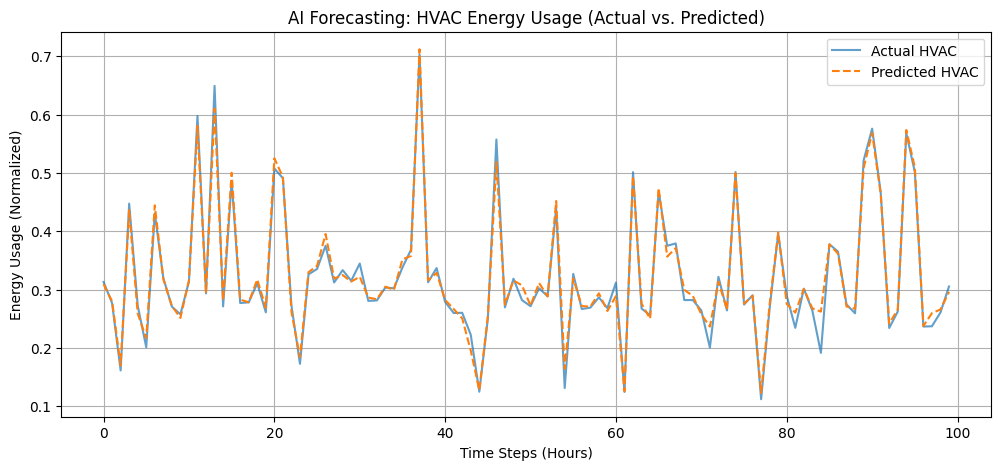

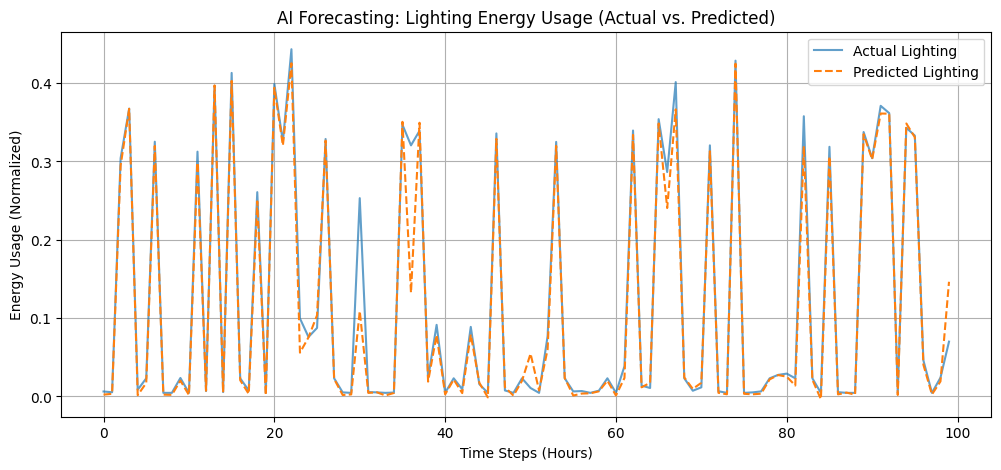

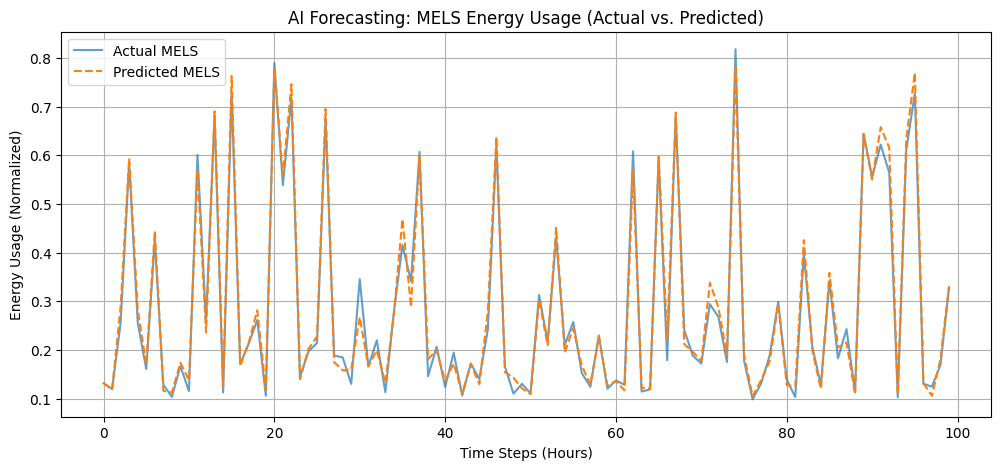

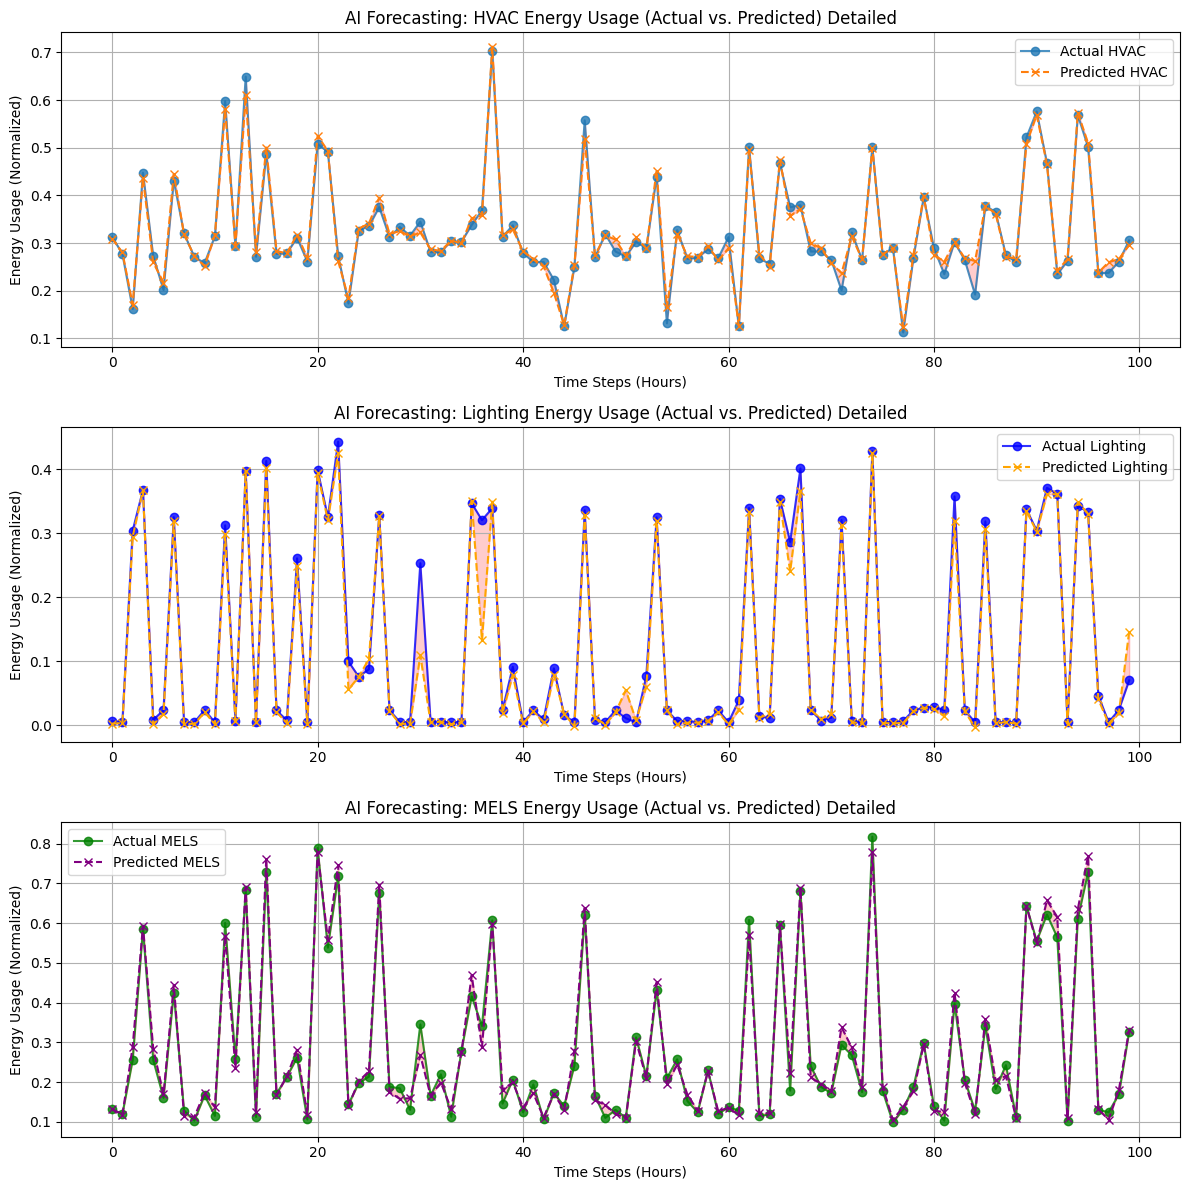

<Figure size 1200x500 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


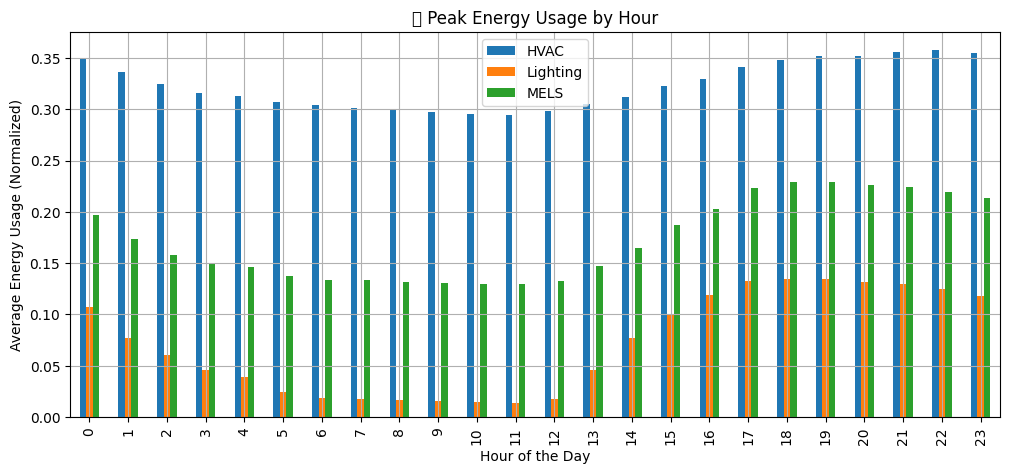

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


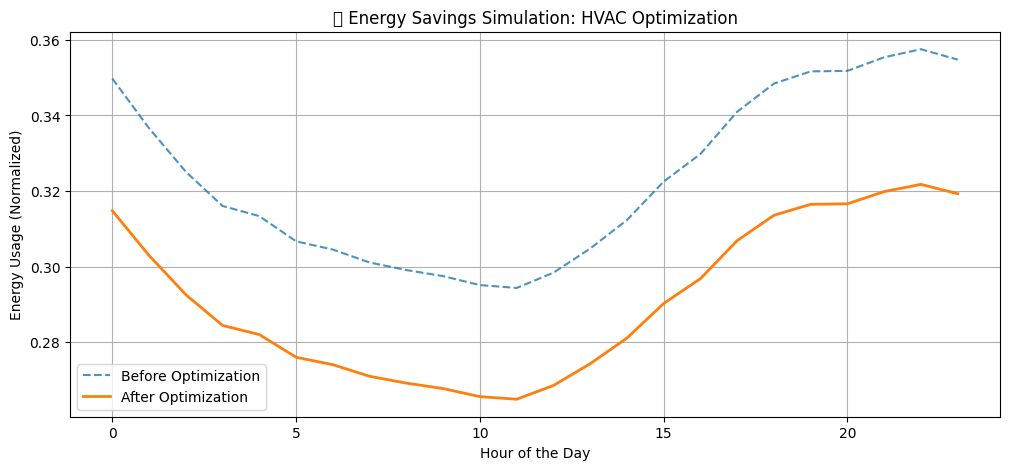

In [16]:
# Predict & Evaluate Model
model = load_model("/content/hourly_energy_prediction.keras")

y_pred = model.predict(X_test, batch_size=32)

# Calculate Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error

mae_hvac = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_lighting = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
mae_mels = mean_absolute_error(y_test[:, 2], y_pred[:, 2])

print(f"Model Evaluated!")
print(f"MAE - HVAC: {mae_hvac:.2f}")
print(f"MAE - Lighting: {mae_lighting:.2f}")
print(f"MAE - MELS: {mae_mels:.2f}")

# Plot evaluation results
# HVAC Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100, 0], label="Actual HVAC", alpha=0.7)
plt.plot(y_pred[:100, 0], label="Predicted HVAC", linestyle="dashed")
plt.legend()
plt.title("AI Forecasting: HVAC Energy Usage (Actual vs. Predicted)")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Energy Usage (Normalized)")
plt.grid(True)
plt.show()

# Lighting Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100, 1], label="Actual Lighting", alpha=0.7)
plt.plot(y_pred[:100, 1], label="Predicted Lighting", linestyle="dashed")
plt.legend()
plt.title("AI Forecasting: Lighting Energy Usage (Actual vs. Predicted)")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Energy Usage (Normalized)")
plt.grid(True)
plt.show()

# MELS Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100, 2], label="Actual MELS", alpha=0.7)
plt.plot(y_pred[:100, 2], label="Predicted MELS", linestyle="dashed")
plt.legend()
plt.title("AI Forecasting: MELS Energy Usage (Actual vs. Predicted)")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Energy Usage (Normalized)")
plt.grid(True)
plt.show()

# Compute absolute errors
error_hvac = np.abs(y_test[:100, 0] - y_pred[:100, 0])
error_lighting = np.abs(y_test[:100, 1] - y_pred[:100, 1])
error_mels = np.abs(y_test[:100, 2] - y_pred[:100, 2])

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

# HVAC Plot Detailed
axes[0].plot(y_test[:100, 0], label="Actual HVAC", alpha=0.8, marker="o")
axes[0].plot(y_pred[:100, 0], label="Predicted HVAC", linestyle="dashed", marker="x")
axes[0].fill_between(range(100), y_test[:100, 0], y_pred[:100, 0], color="red", alpha=0.2)  # Shade error
axes[0].legend()
axes[0].set_title("AI Forecasting: HVAC Energy Usage (Actual vs. Predicted) Detailed")
axes[0].set_ylabel("Energy Usage (Normalized)")
axes[0].set_xlabel("Time Steps (Hours)")
axes[0].grid(True)

# Lighting Plot Detailed
axes[1].plot(y_test[:100, 1], label="Actual Lighting", alpha=0.8, marker="o", color="blue")
axes[1].plot(y_pred[:100, 1], label="Predicted Lighting", linestyle="dashed", marker="x", color="orange")
axes[1].fill_between(range(100), y_test[:100, 1], y_pred[:100, 1], color="red", alpha=0.2)
axes[1].legend()
axes[1].set_title("AI Forecasting: Lighting Energy Usage (Actual vs. Predicted) Detailed")
axes[1].set_ylabel("Energy Usage (Normalized)")
axes[1].set_xlabel("Time Steps (Hours)")
axes[1].grid(True)

# MELS Plot Detailed
axes[2].plot(y_test[:100, 2], label="Actual MELS", alpha=0.8, marker="o", color="green")
axes[2].plot(y_pred[:100, 2], label="Predicted MELS", linestyle="dashed", marker="x", color="purple")
axes[2].fill_between(range(100), y_test[:100, 2], y_pred[:100, 2], color="red", alpha=0.2)
axes[2].legend()
axes[2].set_title("AI Forecasting: MELS Energy Usage (Actual vs. Predicted) Detailed")
axes[2].set_ylabel("Energy Usage (Normalized)")
axes[2].set_xlabel("Time Steps (Hours)")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Show some possible energy savings insights

plt.figure(figsize=(12, 5))
hourly_avg = merged_df.groupby("hour")[["total_hvac", "total_lighting", "total_mels"]].mean()
hourly_avg.plot(kind="bar", figsize=(12, 5))
plt.title("🔍 Peak Energy Usage by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Energy Usage (Normalized)")
plt.legend(["HVAC", "Lighting", "MELS"])
plt.grid(True)
plt.show()

# Simulated optimized energy use: Reduce peak by 10%
optimized_usage = hourly_avg * 0.90  # Assume 10% energy savings

plt.figure(figsize=(12, 5))
plt.plot(hourly_avg["total_hvac"], label="Before Optimization", linestyle="dashed", alpha=0.8)
plt.plot(optimized_usage["total_hvac"], label="After Optimization", linewidth=2)
plt.title("🏢 Energy Savings Simulation: HVAC Optimization")
plt.xlabel("Hour of the Day")
plt.ylabel("Energy Usage (Normalized)")
plt.legend()
plt.grid(True)
plt.show()